In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

tsdm_df = pd.read_csv('Datasets/tsdm.csv')

tsdm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3691 entries, 0 to 3690
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PADDOCK_ID          3691 non-null   object 
 1   OBSERVATION_DATE    3691 non-null   object 
 2   TSDM                3691 non-null   float64
 3   15D_AVG_DAILY_RAIN  3691 non-null   float64
 4   15D_AVG_MAX_TEMP    3691 non-null   float64
 5   15D_AVG_MIN_TEMP    3691 non-null   float64
 6   15D_AVG_RH_TMAX     3691 non-null   float64
 7   15D_AVG_RH_TMIN     3691 non-null   float64
 8   15D_AVG_EVAP_SYN    3691 non-null   float64
 9   15D_AVG_RADIATION   3691 non-null   float64
dtypes: float64(8), object(2)
memory usage: 288.5+ KB


In [4]:
print(tsdm_df['OBSERVATION_DATE'])

0       2017-02-04
1       2017-02-19
2       2017-03-06
3       2017-03-21
4       2017-04-05
           ...    
3686    2024-10-25
3687    2024-11-09
3688    2024-11-24
3689    2024-12-09
3690    2024-12-24
Name: OBSERVATION_DATE, Length: 3691, dtype: object


In [ ]:
#preprocessing

tsdm_df['OBSERVATION_DATE'] = pd.to_datetime(tsdm_df['OBSERVATION_DATE'])

In [ ]:
def create_sequences(sequence, lookback, forecast_horizon, target_col):
    #returns a tuple describing the dimensions of the 2D NumPy array
    #T tells us how long the full series is.
    #num_features tells us how many variables we have per time step.
    T, num_features = sequence.shape
    #lengths: stores the actual length of each window (useful if some are shorter)
    X, y, lengths = [], [], []
    #pre-pad shorter sequences to a fixed length
    pad_vector = np.zeros((lookback, num_features))

        # loops over each time step, stopping early enough so we can still forecast forecast_horizon steps ahead
    for t in range(1, T - forecast_horizon + 1):
        #context = all timesteps up to but not including time t
        # If there are more than lookback timesteps, keep only the most recent lookback steps
        context = sequence[:t]
        if len(context) > lookback:
            context = context[-lookback:]
#If the context is shorter than lookback, it’s pre-padded with zeros on top.
# This ensures all inputs have the same shape (lookback, num_features).
        padded_context = pad_vector.copy()
        padded_context[-len(context):] = context
#Store input/target Pairs
        X.append(padded_context)
        y.append(sequence[t:t + forecast_horizon, target_col])
        lengths.append(min(len(context), lookback))
#Returns:
# X: shape  (num_samples, lookback, num_features)
# y: shape  (num_samples, forecast_horizon)
#lengths: list of true sequence lengths before padding
    return np.array(X), np.array(y), lengths

In [7]:
import sys
!{sys.executable} -m pip install torch

   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 1.6/241.3 MB 9.3 MB/s eta 0:00:26
    --------------------------------------- 3.9/241.3 MB 10.2 MB/s eta 0:00:24
   - -------------------------------------- 6.3/241.3 MB 10.7 MB/s eta 0:00:22
   - -------------------------------------- 8.7/241.3 MB 10.7 MB/s eta 0:00:22
   - -------------------------------------- 10.7/241.3 MB 10.6 MB/s eta 0:00:22
   -- ------------------------------------- 12.8/241.3 MB 10.6 MB/s eta 0:00:22
   -- ------------------------------------- 14.9/241.3 MB 10.7 MB/s eta 0:00:22
   -- ------------------------------------- 17.3/241.3 MB 10.5 MB/s eta 0:00:22
   --- ------------------------------------ 19.9/241.3 MB 10.6 MB/s eta 0:00:21
   --- ------------------------------------ 22.3/241.3 MB 10.7 MB/s eta 0:00:21
   ---- ----------------------------------- 24.6/241.3 MB 10.8 MB/s eta 0:00:21
   ---- ----------------------------------- 27.3/241.3

In [ ]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

def data_prep(df, feature_columns, lookback, test_steps, target_col):
    # Prepare to store all training data
    #Inputs and outputs for all paddocks combined
    X_all, y_all = [], []
    location_ids = []  # To track which location each sample comes from
    test_data = []  # To store test data for each location
    train_data = []
    lengths_all = []  # To store the lengths of each sequence for packing

    # Fit a global scaler
    # collect all training portions (excluding the last test_steps) from every paddock
    # stack them vertically with np.vstack into one large array. 
    all_train_values = []
    for _, group in df.groupby("PADDOCK_ID"):
        feature_values = group[feature_columns].values
        if len(feature_values) > lookback + test_steps:
            all_train_values.append(feature_values[:-test_steps])
    all_train_values = np.vstack(all_train_values)

    global_scaler = MinMaxScaler()
    global_scaler.fit(all_train_values)
    
    # Process each location's data
    for location_id, group in df.groupby("PADDOCK_ID"):
        feature_values = group[feature_columns].values

        # If there are not enough samples for training, skip this location

        min_required = lookback + test_steps
        if len(feature_values) <= min_required:
            continue
            
        # Separate the last certain steps for testing
        # Scale the data
        train_sample = global_scaler.transform(feature_values[:-test_steps])
        test_sample = global_scaler.transform(feature_values[-test_steps:])
        
        # If you prefer without scaling
        #train_sample = feature_values[:-test_steps]
        #test_sample = feature_values[-test_steps:]
        
        train_data.append((location_id, train_sample))
        test_data.append((location_id, test_sample, global_scaler))  # Store test data and scaler

        # Prepare LSTM sequence data for training
        X_location, y_location, lengths = create_sequences(train_sample, lookback, test_steps, target_col)

        # Append to the overall dataset
        X_all.append(X_location)
        y_all.append(y_location)
        lengths_all.append(lengths)  # Store sequence lengths

        # Store Location ID for tracking
        location_ids.extend([location_id] * len(y_location))

    # Concatenate all locations' training data for model training
    X_all = np.concatenate(X_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    lengths_all = np.concatenate(lengths_all, axis=0)  # Concatenate sequence lengths

    # Reshape X to be [samples, time steps, features] as required by LSTM
    X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], X_all.shape[2]))  
    
    return torch.Tensor(X_all), torch.Tensor(y_all), torch.Tensor(lengths_all), train_data, test_data


In [15]:
#use this function to create sequences for `TSDM`, 
#and split it into the training/testing set. 
# we will use 5 time points in the past (`lookback`) to predict 5 time points in the future (`test_steps`). 
# The `target_col` refers to the index of the target attribute for prediction. 
# As this is a univariate model, the value `0` will represent the input as well as target.

lookback = 5
test_steps = 5
target_col = 0
X_5, y_5, lengths_5, train_d_5, test_d_5 = data_prep(tsdm_df,['TSDM'],lookback,test_steps, target_col)

print("Shape of input data after sequence creation:", X_5.shape)
print("Shape of targets after sequence creation:", y_5.shape)

Shape of input data after sequence creation: torch.Size([3501, 5, 1])
Shape of targets after sequence creation: torch.Size([3501, 5])


In [10]:
# Defining the LSTM network

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class MyLSTMNet(nn.Module):
    def __init__(self, num_features, hidden_layer_size, num_layers, output_size, dropout_prob):
        super().__init__()
        self.lstm = nn.LSTM(input_size=num_features,  
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, data, lengths):
        # Pack the input sequence - This ensures that the LSTM ignores padded values during computation.
        packed_data = pack_padded_sequence(data, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Run through LSTM
        packed_output, (hn, cn) = self.lstm(packed_data)

        # Use the last layer's hidden state
        last_hidden = hn[-1]  

        # Apply dropout and final linear layer
        out = self.dropout(last_hidden)
        out = self.fc(out)  
        return out


In [ ]:
#initialize the necessary parameters for the LSTM model
# (to be done later)

'''num_features = X_5.shape[2]
hidden_layer_size = 10
output_size = test_steps
num_layers = 2
dropout_prob = 0.2
model_lstm_5 = MyLSTMNet(num_features, hidden_layer_size, num_layers, output_size,dropout_prob)

print(model_lstm_5)'''

MyLSTMNet(
  (lstm): LSTM(1, 10, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=10, out_features=5, bias=True)
)


In [ ]:
#compute the root mean square error of the model's predictions
# use `root_mean_squared_error` from scikit-learn.
#compute the R^2 score in a similar manner.
#plot the predictions that the LSTM model has made and compare them to the labelled data.

import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

def pred_eval(model, X, y, lengths, train_d, test_d, lookback, target_col):
    #set model to evaluation mode
    model.eval()
    #disable gradient computation
    with torch.no_grad():
        #X: training input tensor ([samples, lookback, features])
        #lengths: true sequence lengths for each sample (used for packed LSTM input)
        #train_preds: model's predicted next 5 timesteps for each training sequence
        train_preds = model(X, lengths)
        print("Training RMSE:",root_mean_squared_error(y.flatten().tolist(),train_preds.flatten().tolist()))
        print("Training R2:", r2_score(y.flatten().tolist(),train_preds.flatten().tolist()))
        X_test = []
        y_test = []
        lengths_test = []
        #take the last lookback timesteps from the training portion as input context.
        # use the next test_steps timesteps (test_values) as ground truth.
        # store their lengths (should all be 5 here).
        # so each test sample uses the last lookback of training to predict the next test_steps.
        for count, (location_id, test_values, scaler) in enumerate(test_d):
            train_values = train_d[count][1]
            X_test.append(train_values[-lookback:])
            y_test.append(test_values[:,target_col])
            # Append the actual lengths (just like the training phase)
            lengths_test.append(len(train_values[-lookback:]))  
        X_test = torch.Tensor(np.array(X_test)) 
        y_test = torch.Tensor(np.array(y_test))
        lengths_test = torch.Tensor(lengths_test).long()
        test_preds = model(X_test,lengths_test)
        #print(y_test.flatten().tolist())
        #print(test_preds.flatten().tolist())
        print("Test RMSE:",root_mean_squared_error(y_test.flatten().tolist(),test_preds.flatten().tolist()))
        print("Test R2:", r2_score(y_test.flatten().tolist(),test_preds.flatten().tolist()))
        plt.figure(figsize=(10, 6))
        plt.plot(y_test.flatten().tolist(), label="Expected Value")
        plt.plot(test_preds.flatten().tolist(), label="Predicted Value")
        plt.grid()
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

In [ ]:
#hyperparameter tuning

#Grid of Parameters

num_features = X_5.shape[2]
output_size = y_5.shape[1]

# Hidden units: 
hidden_sizes = [s for s in range(10, 31, 10)]

# Layers: 
num_layers_list = [n for n in range(1, 4)]

# Dropout: 
dropout_probs = 0.001 #[round(p, 1) for p in np.arange(0.1, 0.4, 0.1)]

# Learning rates: 
learning_rates = 0.2 #[round(r, 3) for r in np.arange(0.001, 0.005, 0.001)]
results = []

'''for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:
        for dropout_prob in dropout_probs:
            for lr in learning_rates:
                print(f"\nTesting: hidden={hidden_size}, layers={num_layers}, dropout={dropout_prob}, lr={lr}")

                model = MyLSTMNet(
                    num_features=num_features,
                    hidden_layer_size=hidden_size,
                    num_layers=num_layers,
                    output_size=output_size,
                    dropout_prob=dropout_prob
                )

                val_mse = train_and_validate(
                    model,
                    X_train, y_train, lengths_train,
                    X_val, y_val, lengths_val,
                    learning_rate=lr,
                    num_epochs=30,
                    verbose=False
                )

                results.append((hidden_size, num_layers, dropout_prob, lr, val_mse))
                print(f"Validation MSE: {val_mse:.6f}")'''

'for hidden_size in hidden_sizes:\n    for num_layers in num_layers_list:\n        for dropout_prob in dropout_probs:\n            for lr in learning_rates:\n                print(f"\nTesting: hidden={hidden_size}, layers={num_layers}, dropout={dropout_prob}, lr={lr}")\n\n                model = MyLSTMNet(\n                    num_features=num_features,\n                    hidden_layer_size=hidden_size,\n                    num_layers=num_layers,\n                    output_size=output_size,\n                    dropout_prob=dropout_prob\n                )\n\n                val_mse = train_and_validate(\n                    model,\n                    X_train, y_train, lengths_train,\n                    X_val, y_val, lengths_val,\n                    learning_rate=lr,\n                    num_epochs=30,\n                    verbose=False\n                )\n\n                results.append((hidden_size, num_layers, dropout_prob, lr, val_mse))\n                print(f"Validation MSE:


=== Training model: hidden=10, layers=1, dropout=0.001, lr=0.2 ===
Final Training Loss: 0.008857

Evaluating model performance...
Training RMSE: 0.0938289940458206
Training R2: 0.4673955428409414
Test RMSE: 0.06727665471978156
Test R2: 0.44571330954140687


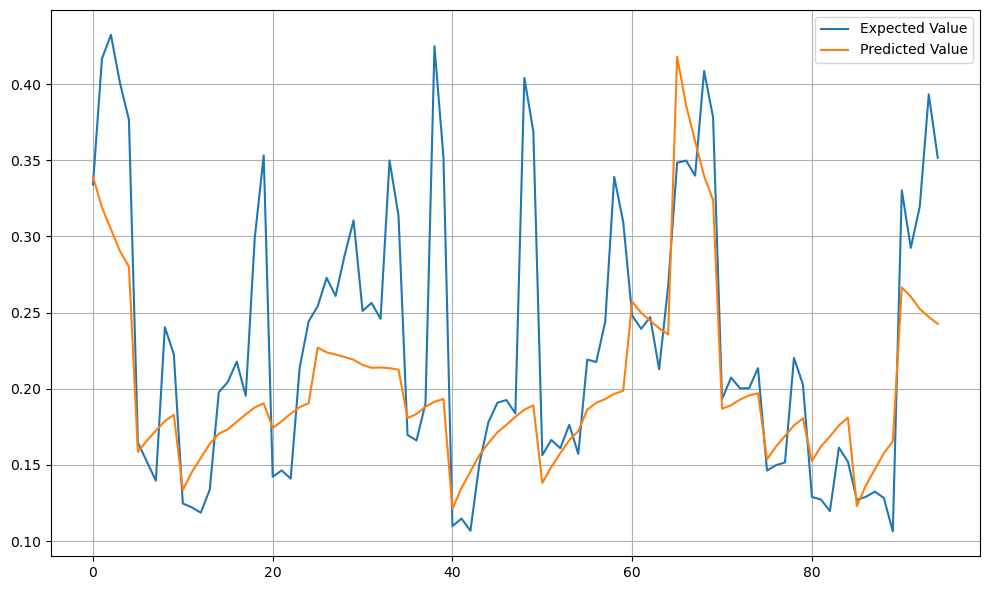


=== Training model: hidden=10, layers=2, dropout=0.001, lr=0.2 ===
Final Training Loss: 0.008911

Evaluating model performance...
Training RMSE: 0.0925293059607141
Training R2: 0.4820482730655282
Test RMSE: 0.06792343537510996
Test R2: 0.43500453742716616


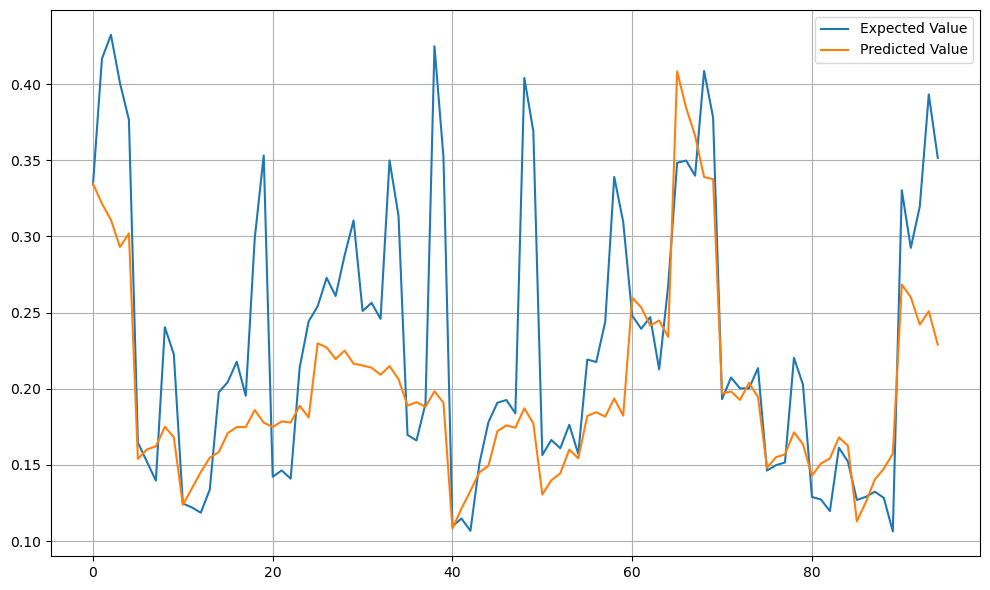


=== Training model: hidden=10, layers=3, dropout=0.001, lr=0.2 ===
Final Training Loss: 0.016513

Evaluating model performance...
Training RMSE: 0.12852348992040463
Training R2: 0.0007004408317943245
Test RMSE: 0.09200351140496958
Test R2: -0.03660781717784922


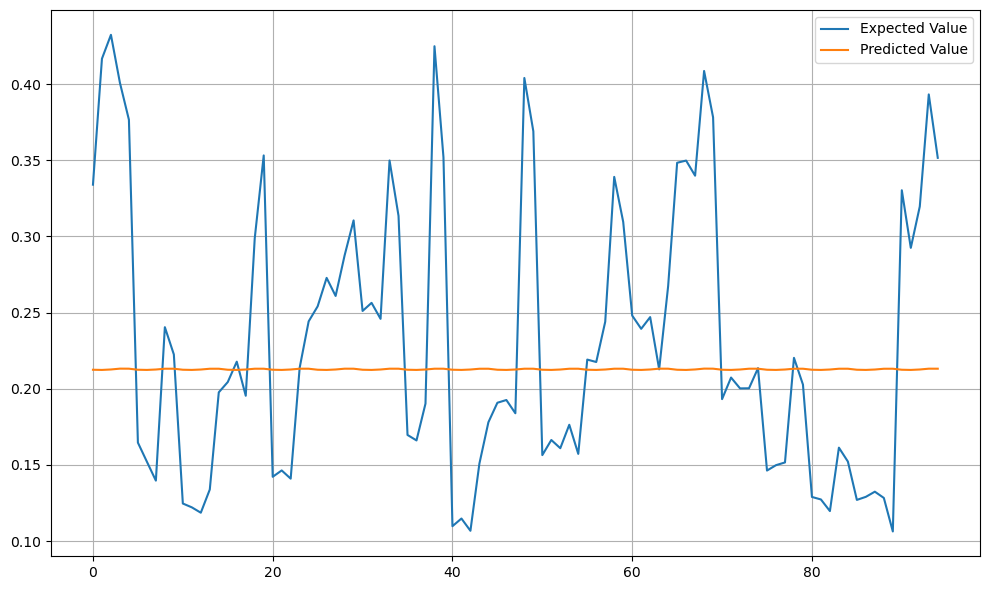


=== Training model: hidden=20, layers=1, dropout=0.001, lr=0.2 ===
Final Training Loss: 0.008671

Evaluating model performance...
Training RMSE: 0.09264081257517781
Training R2: 0.4807991586776823
Test RMSE: 0.0642523461695547
Test R2: 0.49442725349891525


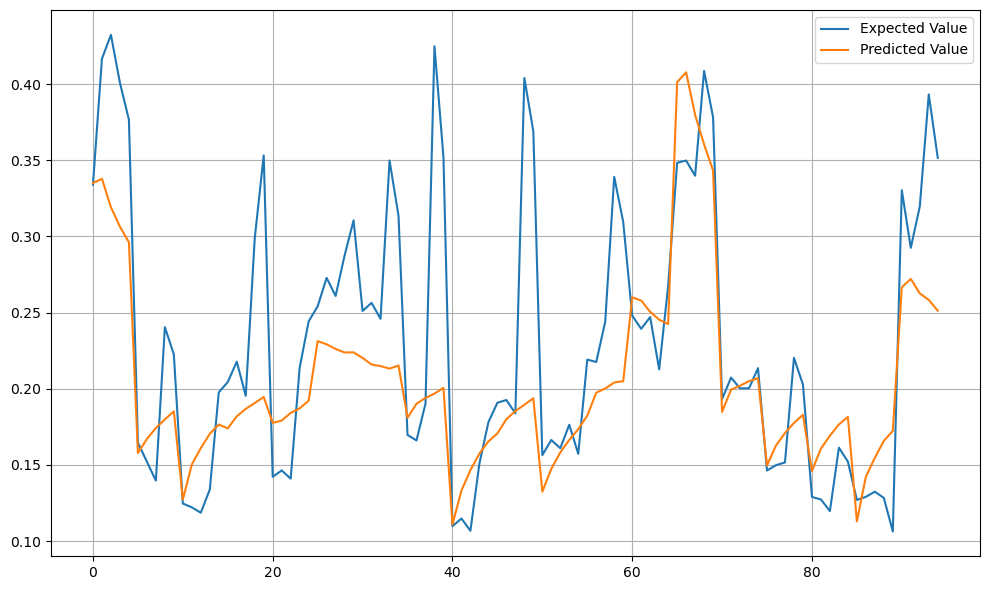


=== Training model: hidden=20, layers=2, dropout=0.001, lr=0.2 ===
Final Training Loss: 0.016671

Evaluating model performance...
Training RMSE: 0.12869995203106213
Training R2: -0.002045509584680971
Test RMSE: 0.09206640701865858
Test R2: -0.03802559720035026


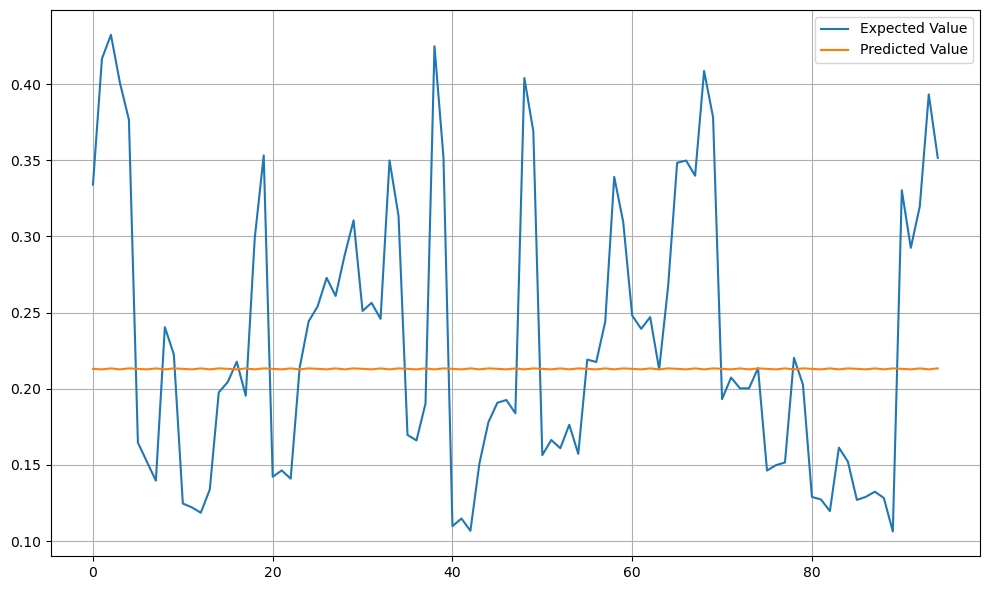


=== Training model: hidden=20, layers=3, dropout=0.001, lr=0.2 ===
Final Training Loss: 0.009179

Evaluating model performance...
Training RMSE: 0.09591534036922579
Training R2: 0.44344662499877097
Test RMSE: 0.06407176498375058
Test R2: 0.4972650839137296


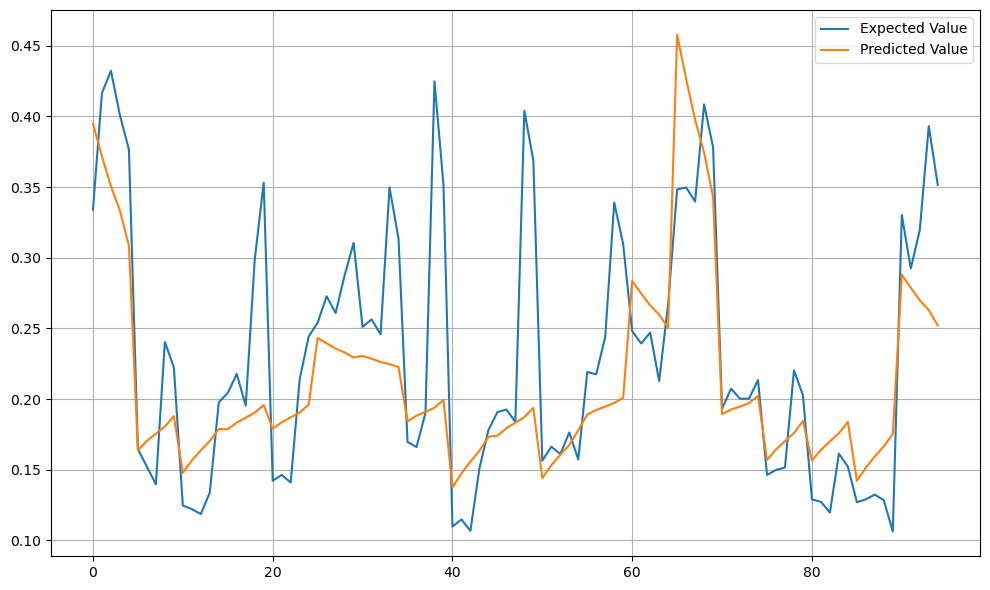


=== Training model: hidden=30, layers=1, dropout=0.001, lr=0.2 ===
Final Training Loss: 0.008891

Evaluating model performance...
Training RMSE: 0.0935167206090613
Training R2: 0.47093477851299026
Test RMSE: 0.0660333426989983
Test R2: 0.46601108885223796


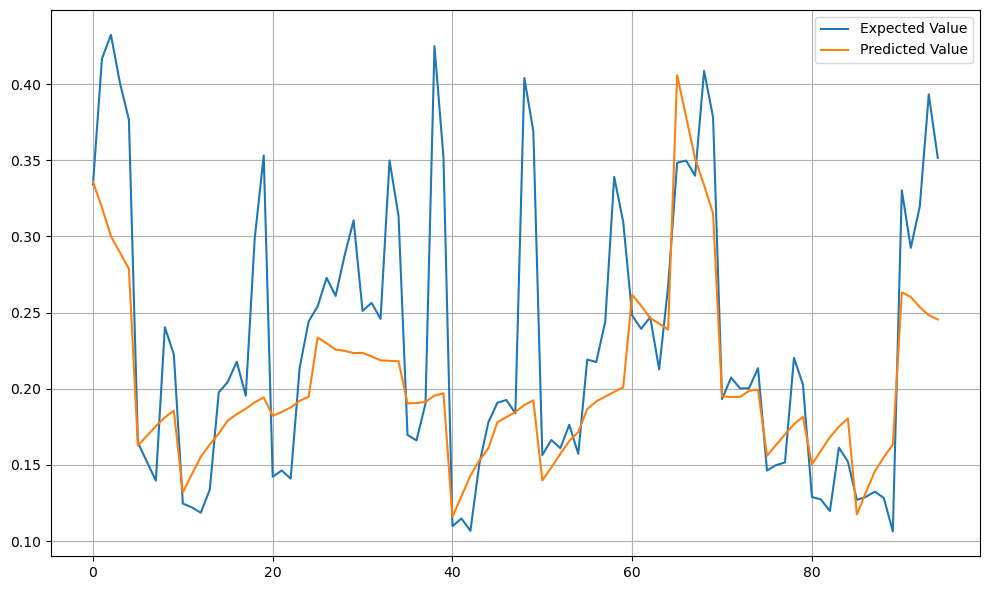


=== Training model: hidden=30, layers=2, dropout=0.001, lr=0.2 ===
Final Training Loss: 0.017039

Evaluating model performance...
Training RMSE: 0.15975215728833972
Training R2: -0.5439176755706088
Test RMSE: 0.14570936557230704
Test R2: -1.6000434653483828


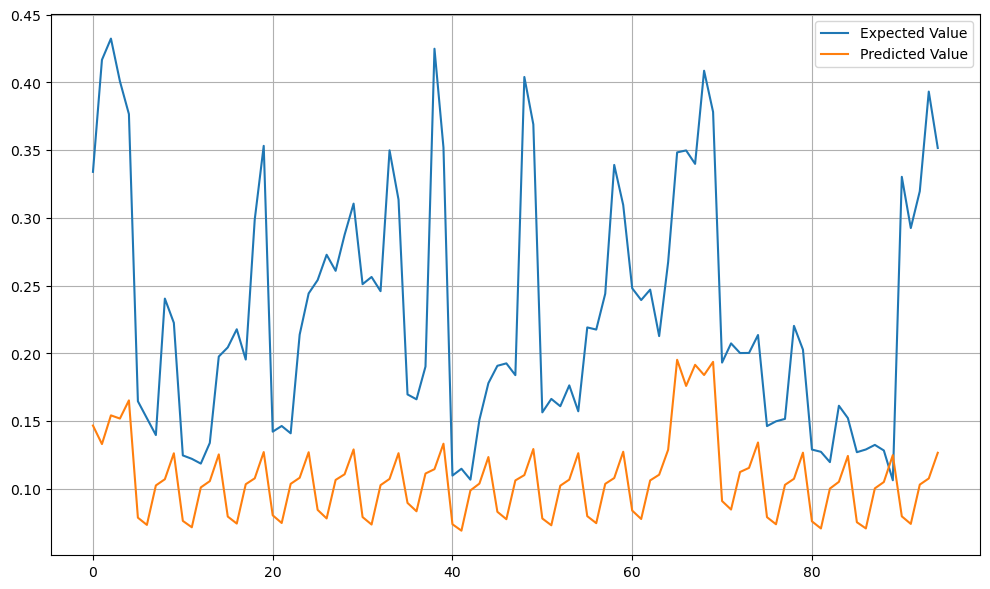


=== Training model: hidden=30, layers=3, dropout=0.001, lr=0.2 ===
Final Training Loss: 0.016635

Evaluating model performance...
Training RMSE: 0.12864606371648774
Training R2: -0.001206546743650394
Test RMSE: 0.0919493896023696
Test R2: -0.03538859018848317


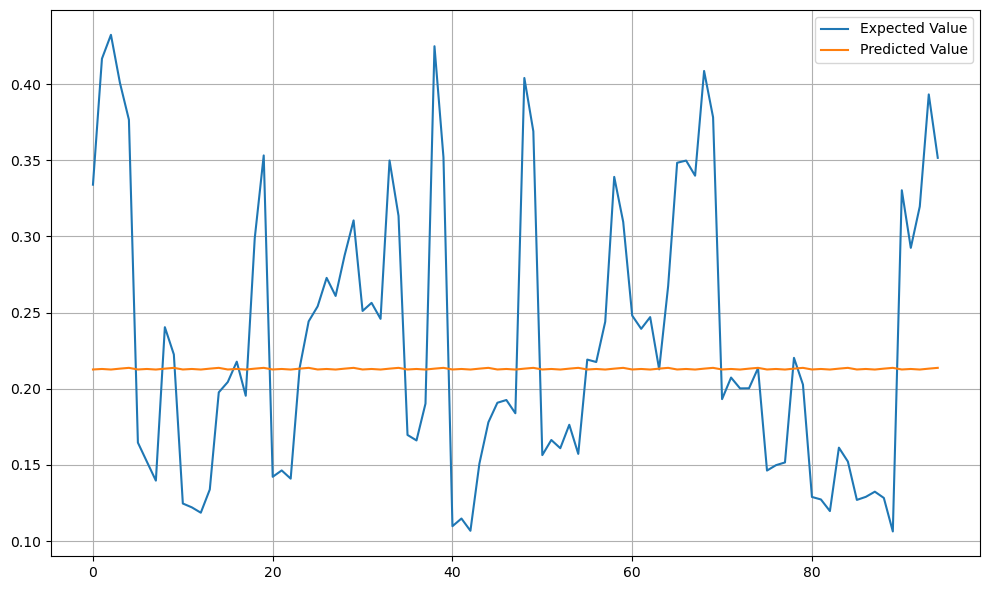


===== Best Model Summary =====
Hidden Size: 10
Num Layers: 2
Dropout: 0.001
Learning Rate: 0.2
Best RMSE: 0.092529


In [35]:
#hyperparameter tuning

#Grid of Parameters

num_features = X_5.shape[2]
output_size = y_5.shape[1]

# Hidden units: 
hidden_sizes = [s for s in range(10, 31, 10)]

# Layers: 
num_layers_list = [n for n in range(1, 4)]

# Dropout: 
dropout_probs = [0.001] #[round(p, 1) for p in np.arange(0.1, 0.4, 0.1)]

# Learning rates: 
learning_rates = [0.2] #[round(r, 3) for r in np.arange(0.001, 0.005, 0.001)]
results = []


best_mse = float("inf")
best_params = None
best_model = None

for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:
        for dropout_prob in dropout_probs:
            for lr in learning_rates:

                print(f"\n=== Training model: hidden={hidden_size}, layers={num_layers}, dropout={dropout_prob}, lr={lr} ===")

                # Create model
                model = MyLSTMNet(
                    num_features=X_5.shape[2],
                    hidden_layer_size=hidden_size,
                    num_layers=num_layers,
                    output_size=y_5.shape[1],
                    dropout_prob=dropout_prob
                )

                # Define loss and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Training loop
                num_epochs = 300
                for epoch in range(num_epochs):
                    model.train()
                    optimizer.zero_grad()
                    outputs = model(X_5, lengths_5)
                    loss = criterion(outputs, y_5)
                    loss.backward()
                    optimizer.step()

                print(f"Final Training Loss: {loss.item():.6f}")

                # Evaluate after training
                print("\nEvaluating model performance...")
                pred_eval(model, X_5, y_5, lengths_5, train_d_5, test_d_5, lookback=5, target_col=0)

                # Track best model by RMSE (test performance)
                model.eval()
                with torch.no_grad():
                    preds = model(X_5, lengths_5)
                    rmse = ((preds - y_5) ** 2).mean().sqrt().item()

                if rmse < best_mse:
                    best_mse = rmse
                    best_params = (hidden_size, num_layers, dropout_prob, lr)
                    best_model = model


print("\n===== Best Model Summary =====")
print(f"Hidden Size: {best_params[0]}")
print(f"Num Layers: {best_params[1]}")
print(f"Dropout: {best_params[2]}")
print(f"Learning Rate: {best_params[3]}")
print(f"Best RMSE: {best_mse:.6f}")



=== Training model: hidden=10, layers=1, dropout=0.5, lr=0.0005 ===
Final Training Loss: 0.036547

Evaluating model performance...
Training RMSE: 0.17351305818326798
Training R2: -0.8213566879484966
Test RMSE: 0.16677759341013673
Test R2: -2.4062857610784767


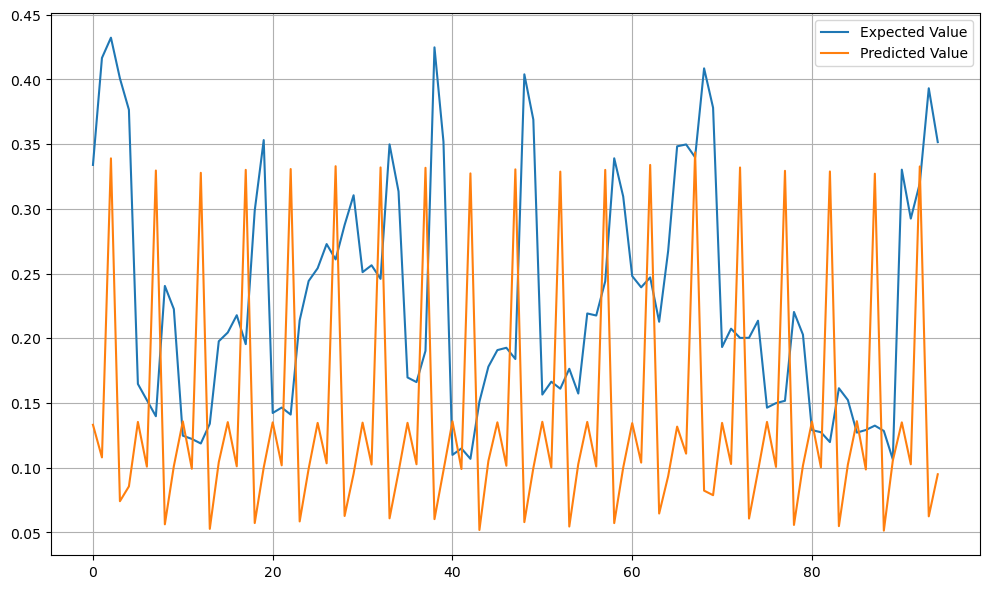


=== Training model: hidden=10, layers=2, dropout=0.5, lr=0.0005 ===
Final Training Loss: 0.051786

Evaluating model performance...
Training RMSE: 0.22225277466799717
Training R2: -1.9883059476146716
Test RMSE: 0.2315626560618551
Test R2: -5.566632600143947


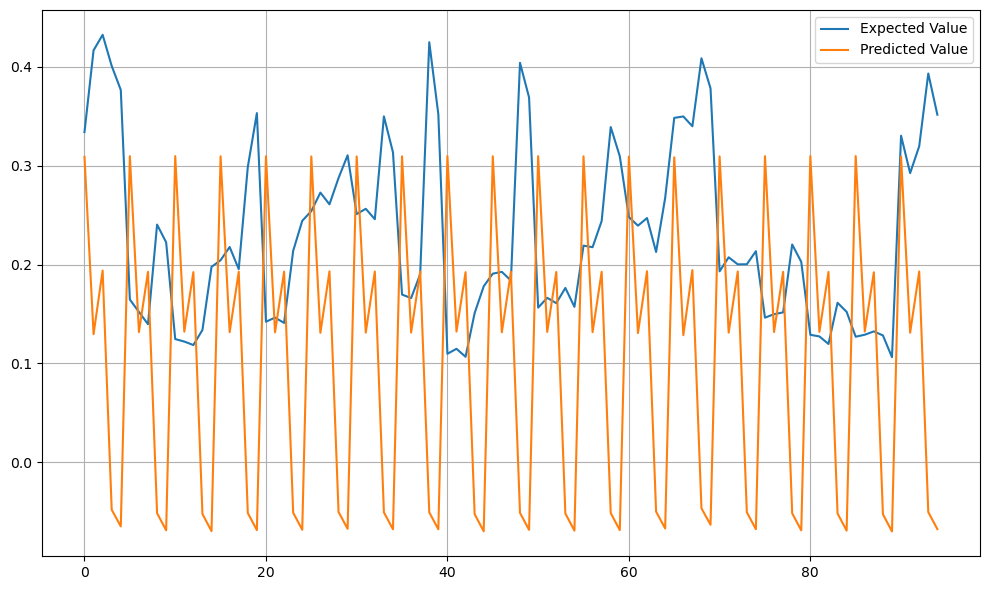


=== Training model: hidden=10, layers=3, dropout=0.5, lr=0.0005 ===
Final Training Loss: 0.037604

Evaluating model performance...
Training RMSE: 0.17871776822277918
Training R2: -0.9322625692651156
Test RMSE: 0.16521528839333305
Test R2: -2.3427672552825873


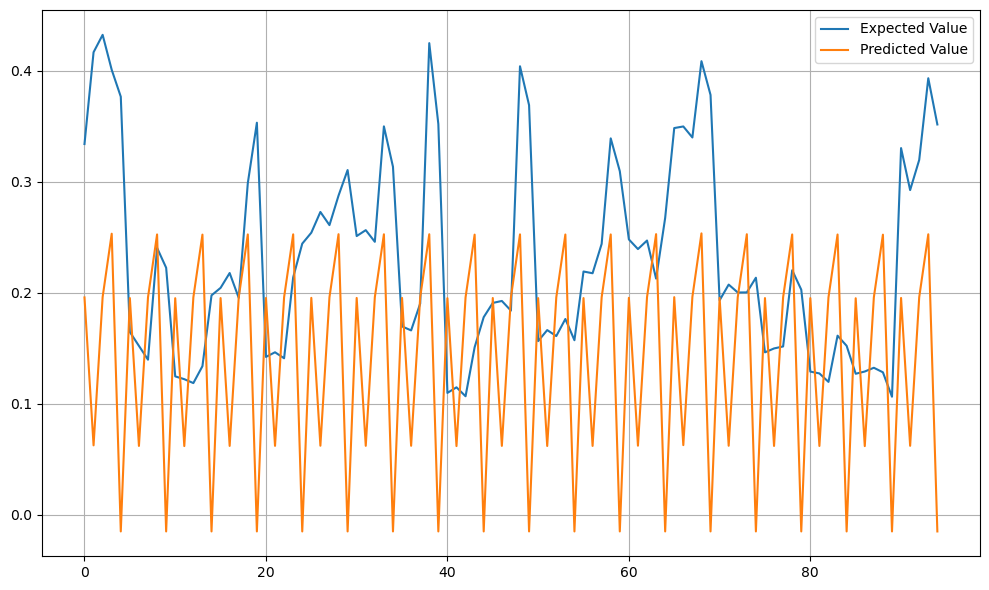


=== Training model: hidden=20, layers=1, dropout=0.5, lr=0.0005 ===
Final Training Loss: 0.058645

Evaluating model performance...
Training RMSE: 0.23305072061289492
Training R2: -2.2857277557178874
Test RMSE: 0.21665001891318936
Test R2: -4.74808439928412


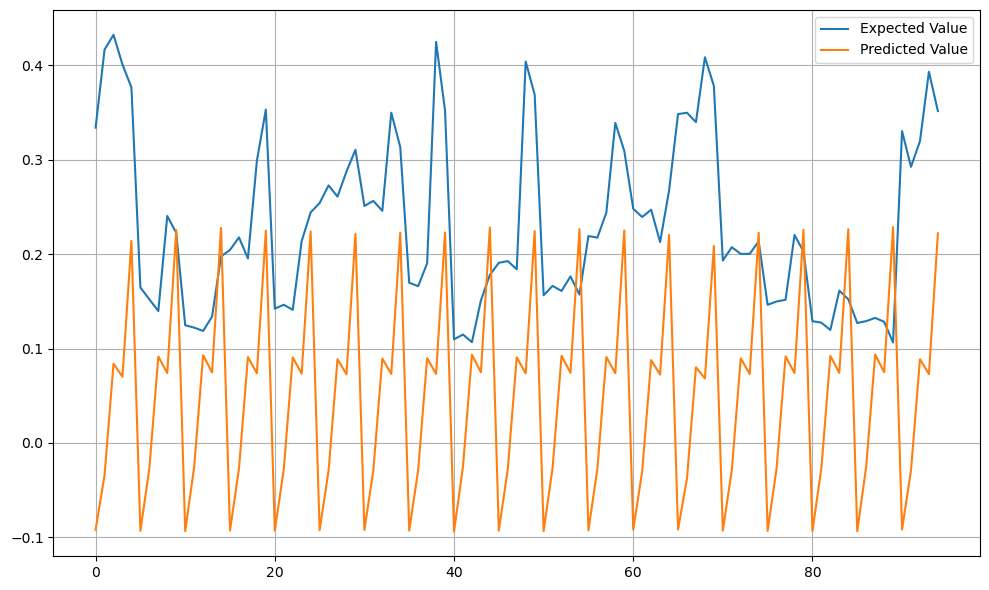


=== Training model: hidden=20, layers=2, dropout=0.5, lr=0.0005 ===
Final Training Loss: 0.053075

Evaluating model performance...
Training RMSE: 0.21406139993815748
Training R2: -1.7720904635379213
Test RMSE: 0.20874337449974686
Test R2: -4.336187405630581


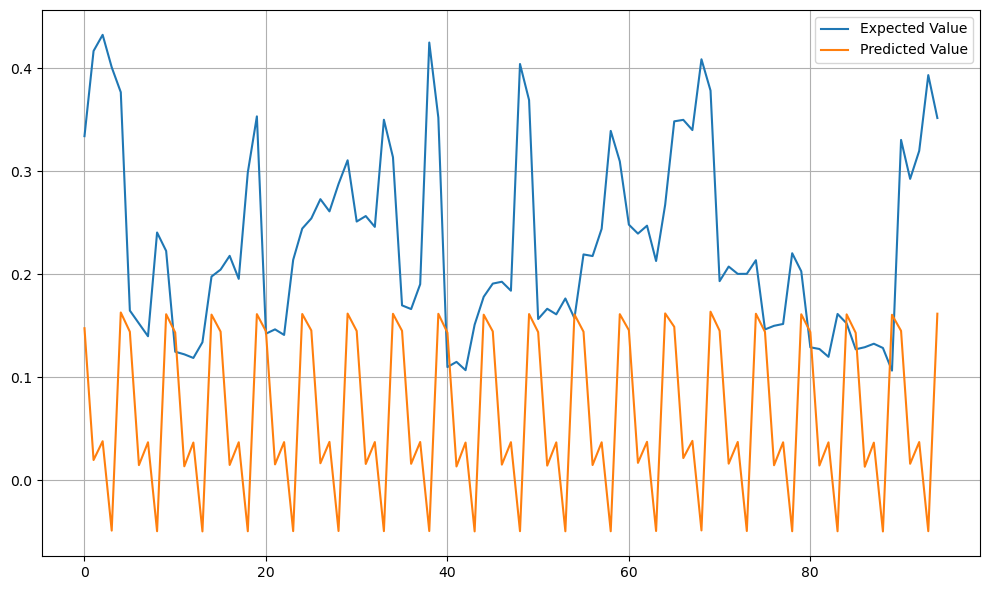


=== Training model: hidden=20, layers=3, dropout=0.5, lr=0.0005 ===
Final Training Loss: 0.043860

Evaluating model performance...
Training RMSE: 0.1719540385118474
Training R2: -0.7887738460280351
Test RMSE: 0.15680522561573887
Test R2: -2.0111108034313774


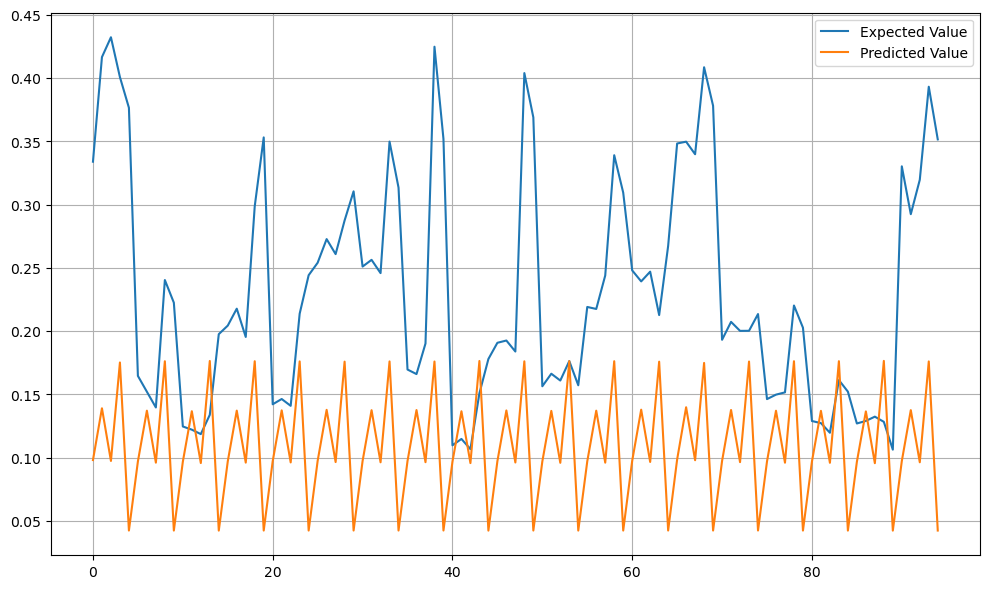


=== Training model: hidden=30, layers=1, dropout=0.5, lr=0.0005 ===
Final Training Loss: 0.029508

Evaluating model performance...
Training RMSE: 0.15605249121614806
Training R2: -0.47323520494703075
Test RMSE: 0.1321440775504694
Test R2: -1.1384597528726137


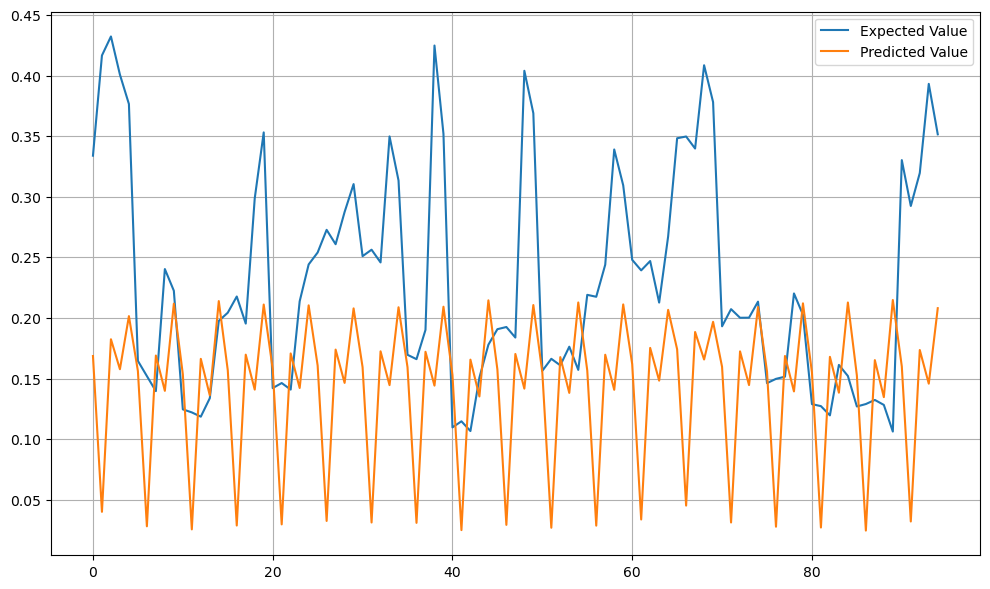


=== Training model: hidden=30, layers=2, dropout=0.5, lr=0.0005 ===
Final Training Loss: 0.020590

Evaluating model performance...
Training RMSE: 0.12903504060865842
Training R2: -0.007270237594412254
Test RMSE: 0.09321425836640453
Test R2: -0.06407042101367577


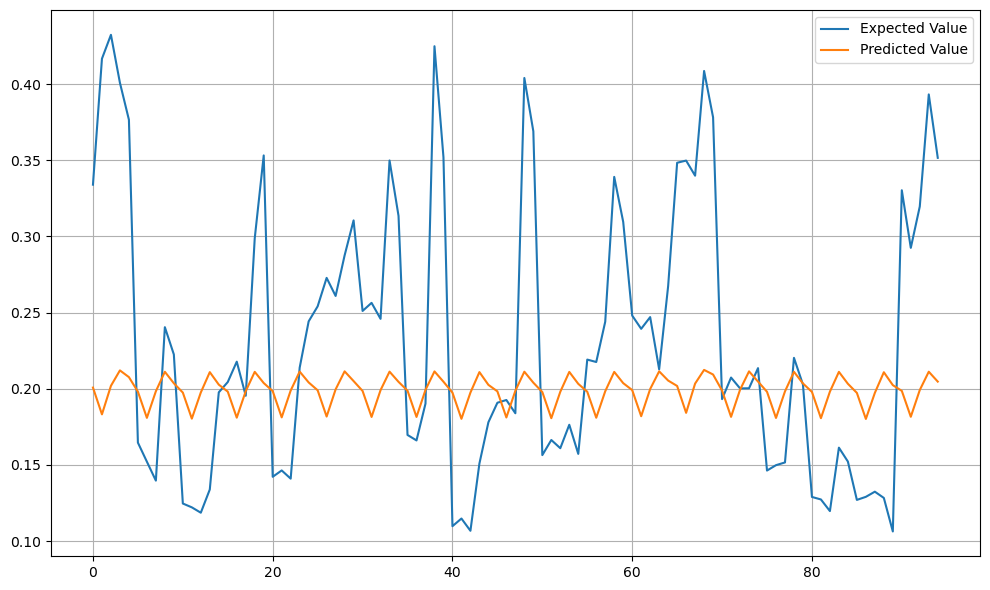


=== Training model: hidden=30, layers=3, dropout=0.5, lr=0.0005 ===
Final Training Loss: 0.025646

Evaluating model performance...
Training RMSE: 0.13006606331755677
Training R2: -0.023431235368836845
Test RMSE: 0.09135801657555923
Test R2: -0.022113202960398315


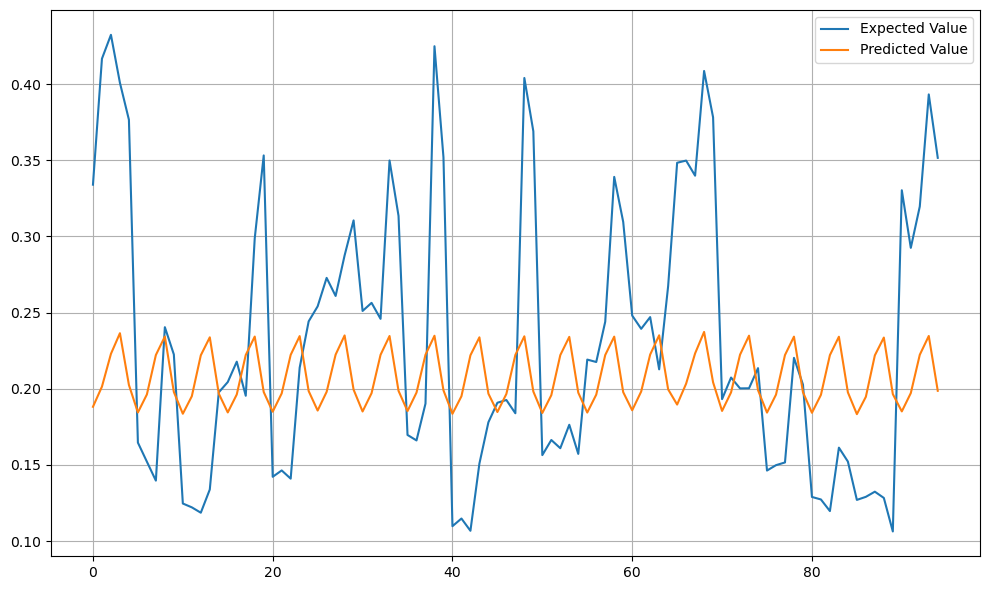


===== Best Model Summary =====
Hidden Size: 30
Num Layers: 2
Dropout: 0.5
Learning Rate: 0.0005
Best RMSE: 0.129035


In [33]:
#hyperparameter tuning

#Grid of Parameters

num_features = X_5.shape[2]
output_size = y_5.shape[1]

# Hidden units: 
hidden_sizes = [s for s in range(10, 31, 10)]

# Layers: 
num_layers_list = [n for n in range(1, 4)]

# Dropout: 
dropout_probs = 0.001 #[round(p, 1) for p in np.arange(0.1, 0.4, 0.1)]

# Learning rates: 
learning_rates = 0.2 #[round(r, 3) for r in np.arange(0.001, 0.005, 0.001)]
results = []

best_mse = float("inf")
best_params = None
best_model = None

for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:
        #for dropout_prob in dropout_probs:
            #for lr in learning_rates:

                print(f"\n=== Training model: hidden={hidden_size}, layers={num_layers}, dropout={dropout_prob}, lr={lr} ===")

                # Create model
                model = MyLSTMNet(
                    num_features=X_5.shape[2],
                    hidden_layer_size=hidden_size,
                    num_layers=num_layers,
                    output_size=y_5.shape[1],
                    dropout_prob=dropout_prob
                )

                # Define loss and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Training loop
                num_epochs = 50
                for epoch in range(num_epochs):
                    model.train()
                    optimizer.zero_grad()
                    outputs = model(X_5, lengths_5)
                    loss = criterion(outputs, y_5)
                    loss.backward()
                    optimizer.step()

                print(f"Final Training Loss: {loss.item():.6f}")

                # Evaluate after training
                print("\nEvaluating model performance...")
                pred_eval(model, X_5, y_5, lengths_5, train_d_5, test_d_5, lookback=5, target_col=0)

                # Track best model by RMSE (test performance)
                model.eval()
                with torch.no_grad():
                    preds = model(X_5, lengths_5)
                    rmse = ((preds - y_5) ** 2).mean().sqrt().item()

                if rmse < best_mse:
                    best_mse = rmse
                    best_params = (hidden_size, num_layers, dropout_prob, lr)
                    best_model = model


print("\n===== Best Model Summary =====")
print(f"Hidden Size: {best_params[0]}")
print(f"Num Layers: {best_params[1]}")
print(f"Dropout: {best_params[2]}")
print(f"Learning Rate: {best_params[3]}")
print(f"Best RMSE: {best_mse:.6f}")